In [23]:
# Cell 1 - Modified Imports
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import clip
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm  # Changed from tqdm.notebook
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib backend
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend

In [33]:
# Cell 5 - Modified Plotting Functions with explicit style settings
def plot_training_curves(history, run_dir):
    """Plot and save training metrics."""
    # Set style parameters explicitly instead of using seaborn style
    plt.rcParams.update({
        'figure.figsize': (15, 5),
        'axes.grid': True,
        'grid.alpha': 0.3,
        'axes.labelsize': 10,
        'axes.titlesize': 12,
        'legend.fontsize': 10,
        'lines.linewidth': 2,
        'font.family': 'sans-serif'
    })
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    # Loss plot
    ax1.plot(history['epochs'], history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(history['epochs'], history['val_loss'], 'r-', label='Val Loss')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(history['epochs'], history['train_acc'], 'b-', label='Train Acc')
    ax2.plot(history['epochs'], history['val_acc'], 'r-', label='Val Acc')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # F1 Score plot
    ax3.plot(history['epochs'], history['train_f1'], 'b-', label='Train F1')
    ax3.plot(history['epochs'], history['val_f1'], 'r-', label='Val F1')
    ax3.set_title('F1 Score Over Time')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'training_curves.png'))
    plt.close()

def plot_confusion_matrix(cm, run_dir, phase='test'):
    """Plot and save confusion matrix."""
    plt.figure(figsize=(8, 6))
    
    # Create heatmap manually instead of using seaborn
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'{phase.capitalize()} Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    classes = ['Normal', 'Cataract']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add value annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, f'{phase}_confusion_matrix.png'))
    plt.close()

In [25]:
# Cell 2 - Setup Directories and Device
# Create base directories
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATA_DIR = os.path.join(BASE_DIR, "processed_images/train")
TEST_DIR = os.path.join(BASE_DIR, "processed_images/test")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# Create timestamp directory for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(RESULTS_DIR, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Set device and random seed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = True

print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Results will be saved in: {run_dir}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
Results will be saved in: e:\jivi-ai\results\run_20241025_203223


In [26]:
# Cell 3 - Dataset Class
class CataractDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load cataract images
        cataract_dir = os.path.join(root_dir, "cataract")
        if os.path.exists(cataract_dir):
            for img_name in os.listdir(cataract_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(cataract_dir, img_name))
                    self.labels.append(1)
        
        # Load normal images
        normal_dir = os.path.join(root_dir, "normal")
        if os.path.exists(normal_dir):
            for img_name in os.listdir(normal_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(normal_dir, img_name))
                    self.labels.append(0)
        
        print(f"Found {len(self.images)} images")
        print(f"Cataract images: {self.labels.count(1)}")
        print(f"Normal images: {self.labels.count(0)}")
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return torch.zeros((3, 224, 224)), self.labels[idx]

In [27]:
# Cell 4 - Model Class
class CataractClassifier(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip_model = clip_model
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        with torch.no_grad():
            features = self.clip_model.encode_image(x)
            features = features.float()
        return self.classifier(features)

In [28]:
# Cell 5 - Plotting Functions
def plot_training_curves(history, run_dir):
    """Plot and save training metrics."""
    plt.style.use('seaborn')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['epochs'], history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(history['epochs'], history['val_loss'], 'r-', label='Val Loss')
    ax1.set_title('Loss Over Time', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.legend()
    
    # Accuracy plot
    ax2.plot(history['epochs'], history['train_acc'], 'b-', label='Train Acc')
    ax2.plot(history['epochs'], history['val_acc'], 'r-', label='Val Acc')
    ax2.set_title('Accuracy Over Time', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Accuracy', fontsize=10)
    ax2.legend()
    
    # F1 Score plot
    ax3.plot(history['epochs'], history['train_f1'], 'b-', label='Train F1')
    ax3.plot(history['epochs'], history['val_f1'], 'r-', label='Val F1')
    ax3.set_title('F1 Score Over Time', fontsize=12)
    ax3.set_xlabel('Epoch', fontsize=10)
    ax3.set_ylabel('F1 Score', fontsize=10)
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'training_curves.png'))
    plt.close()

def plot_confusion_matrix(cm, run_dir, phase='test'):
    """Plot and save confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Cataract'],
                yticklabels=['Normal', 'Cataract'])
    plt.title(f'{phase.capitalize()} Confusion Matrix', fontsize=12)
    plt.ylabel('True Label', fontsize=10)
    plt.xlabel('Predicted Label', fontsize=10)
    plt.savefig(os.path.join(run_dir, f'{phase}_confusion_matrix.png'))
    plt.close()

In [29]:
# Cell 6 - Evaluation Function
def evaluate_model(model, data_loader, criterion, device, phase='test'):
    """Evaluate model and return metrics."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f'{phase.capitalize()} Evaluation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    metrics = {
        'loss': running_loss/len(data_loader),
        'accuracy': (np.array(all_preds) == np.array(all_labels)).mean(),
        'f1_score': f1_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }
    
    return metrics

In [30]:
# Cell 7 - Setup Training
print("Loading CLIP model...")
clip_model, preprocess = clip.load("RN50", device=device)

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    preprocess
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    preprocess
])

# Create datasets
print("Loading datasets...")
dataset = CataractDataset(DATA_DIR, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

val_dataset.dataset.transform = val_transform

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize model and training components
model = CataractClassifier(clip_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

Loading CLIP model...
Loading datasets...
Found 491 images
Cataract images: 245
Normal images: 246


In [31]:
# Cell 8 - Training Loop
num_epochs = 12
best_f1 = 0
best_epoch = 0

# Metrics tracking
training_history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [],
    'confusion_matrices': [], 'epochs': []
}

print(f"Starting training...")
try:
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Calculate training metrics
        train_loss = train_loss/len(train_loader)
        train_acc = (np.array(train_preds) == np.array(train_labels)).mean()
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        
        # Validation phase
        val_metrics = evaluate_model(model, val_loader, criterion, device, phase='val')
        
        # Store metrics
        training_history['epochs'].append(epoch + 1)
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_acc)
        training_history['train_f1'].append(train_f1)
        training_history['val_loss'].append(val_metrics['loss'])
        training_history['val_acc'].append(val_metrics['accuracy'])
        training_history['val_f1'].append(val_metrics['f1_score'])
        training_history['confusion_matrices'].append(val_metrics['confusion_matrix'])
        
        # Update learning rate
        scheduler.step(val_metrics['loss'])
        
        # Save best model
        if val_metrics['f1_score'] > best_f1:
            best_f1 = val_metrics['f1_score']
            best_epoch = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, os.path.join(run_dir, 'best_model.pth'))
            print(f"Saved new best model with F1: {best_f1:.4f}")
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
        print(f'Val - Loss: {val_metrics["loss"]:.4f}, Acc: {val_metrics["accuracy"]:.4f}, F1: {val_metrics["f1_score"]:.4f}')

except Exception as e:
    print(f"Error during training: {str(e)}")
    raise e

finally:
    # Clean up
    torch.cuda.empty_cache()
    gc.collect()

Starting training...


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Saved new best model with F1: 0.8486

Epoch 1/12:
Train - Loss: 0.6892, Acc: 0.6352, F1: 0.6060
Val - Loss: 0.6799, Acc: 0.8485, F1: 0.8486


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Saved new best model with F1: 0.8587

Epoch 2/12:
Train - Loss: 0.6696, Acc: 0.8903, F1: 0.8903
Val - Loss: 0.6535, Acc: 0.8586, F1: 0.8587


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]



Epoch 3/12:
Train - Loss: 0.6266, Acc: 0.8852, F1: 0.8851
Val - Loss: 0.5962, Acc: 0.8384, F1: 0.8384


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]



Epoch 4/12:
Train - Loss: 0.5481, Acc: 0.8903, F1: 0.8901
Val - Loss: 0.4952, Acc: 0.8485, F1: 0.8486


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Saved new best model with F1: 0.8688

Epoch 5/12:
Train - Loss: 0.4207, Acc: 0.9184, F1: 0.9182
Val - Loss: 0.3719, Acc: 0.8687, F1: 0.8688


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 6/12:
Train - Loss: 0.3215, Acc: 0.9133, F1: 0.9133
Val - Loss: 0.2696, Acc: 0.8687, F1: 0.8686


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Saved new best model with F1: 0.8786

Epoch 7/12:
Train - Loss: 0.2335, Acc: 0.9260, F1: 0.9260
Val - Loss: 0.2115, Acc: 0.8788, F1: 0.8786


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Saved new best model with F1: 0.8890

Epoch 8/12:
Train - Loss: 0.1726, Acc: 0.9439, F1: 0.9438
Val - Loss: 0.1851, Acc: 0.8889, F1: 0.8890


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


Saved new best model with F1: 0.9190

Epoch 9/12:
Train - Loss: 0.1473, Acc: 0.9413, F1: 0.9413
Val - Loss: 0.1681, Acc: 0.9192, F1: 0.9190


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]



Epoch 10/12:
Train - Loss: 0.1308, Acc: 0.9515, F1: 0.9515
Val - Loss: 0.1638, Acc: 0.8990, F1: 0.8991


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Saved new best model with F1: 0.9192

Epoch 11/12:
Train - Loss: 0.1051, Acc: 0.9668, F1: 0.9668
Val - Loss: 0.1485, Acc: 0.9192, F1: 0.9192


Val Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Saved new best model with F1: 0.9393

Epoch 12/12:
Train - Loss: 0.1022, Acc: 0.9745, F1: 0.9745
Val - Loss: 0.1431, Acc: 0.9394, F1: 0.9393


In [34]:
# Cell 9 - Generate Training Plots and Test

print('\nGenerating training plots...')
plot_training_curves(training_history, run_dir)

# Load best model for testing
print('\nLoading best model for testing...')
checkpoint = torch.load(os.path.join(run_dir, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

# Create and evaluate test dataset
test_dataset = CataractDataset(TEST_DIR, transform=val_transform)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

print('\nEvaluating on test set...')
test_metrics = evaluate_model(model, test_loader, criterion, device, phase='test')
plot_confusion_matrix(test_metrics['confusion_matrix'], run_dir, phase='test')

# Save results summary
with open(os.path.join(run_dir, 'results_summary.txt'), 'w') as f:
    f.write(f"Training completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Best F1 Score: {best_f1:.4f} (Epoch {best_epoch+1})\n\n")
    f.write("Test Results:\n")
    f.write(f"Loss: {test_metrics['loss']:.4f}\n")
    f.write(f"Accuracy: {test_metrics['accuracy']:.4f}\n")
    f.write(f"F1 Score: {test_metrics['f1_score']:.4f}\n")
    f.write(f"Precision: {test_metrics['precision']:.4f}\n")
    f.write(f"Recall: {test_metrics['recall']:.4f}\n")

print(f'\nResults saved to {run_dir}')


Generating training plots...

Loading best model for testing...
Found 121 images
Cataract images: 61
Normal images: 60

Evaluating on test set...


Test Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]



Results saved to e:\jivi-ai\results\run_20241025_203223


In [35]:
# Cell 9 - Generate Training Plots and Test
print('\nGenerating training plots...')
plot_training_curves(training_history, run_dir)

# Load best model for testing
print('\nLoading best model for testing...')
checkpoint = torch.load(os.path.join(run_dir, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

# Create and evaluate test dataset
test_dataset = CataractDataset(TEST_DIR, transform=val_transform)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

print('\nEvaluating on test set...')
test_metrics = evaluate_model(model, test_loader, criterion, device, phase='test')
plot_confusion_matrix(test_metrics['confusion_matrix'], run_dir, phase='test')

# Save results summary
with open(os.path.join(run_dir, 'results_summary.txt'), 'w') as f:
    f.write(f"Training completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Best F1 Score: {best_f1:.4f} (Epoch {best_epoch+1})\n\n")
    f.write("Test Results:\n")
    f.write(f"Loss: {test_metrics['loss']:.4f}\n")
    f.write(f"Accuracy: {test_metrics['accuracy']:.4f}\n")
    f.write(f"F1 Score: {test_metrics['f1_score']:.4f}\n")
    f.write(f"Precision: {test_metrics['precision']:.4f}\n")
    f.write(f"Recall: {test_metrics['recall']:.4f}\n")

print(f'\nResults saved to {run_dir}')


Generating training plots...

Loading best model for testing...
Found 121 images
Cataract images: 61
Normal images: 60

Evaluating on test set...


Test Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]



Results saved to e:\jivi-ai\results\run_20241025_203223


Training Progress Curves:


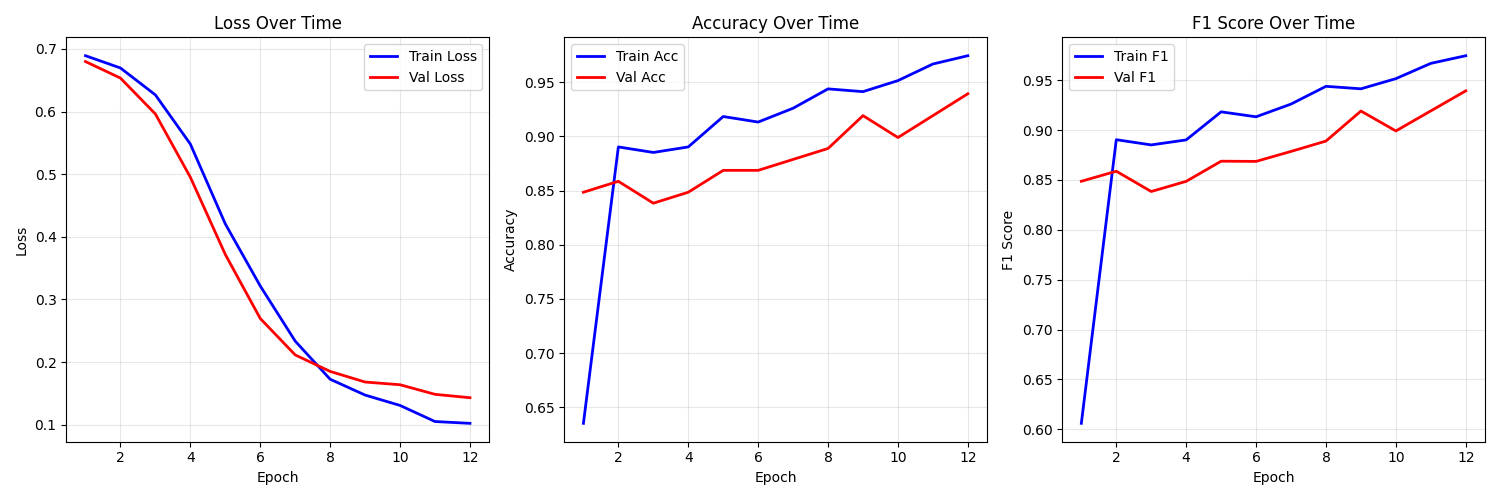


Training Metrics:


,Epoch,Train Loss,Val Loss,Train Acc,Val Acc,Train F1,Val F1
0,1,0.6892,0.6799,0.6352,0.8485,0.6060,0.8486
1,2,0.6696,0.6535,0.8903,0.8586,0.8903,0.8587
2,3,0.6266,0.5962,0.8852,0.8384,0.8851,0.8384
3,4,0.5481,0.4952,0.8903,0.8485,0.8901,0.8486
4,5,0.4207,0.3719,0.9184,0.8687,0.9182,0.8688
5,6,0.3215,0.2696,0.9133,0.8687,0.9133,0.8686
6,7,0.2335,0.2115,0.9260,0.8788,0.9260,0.8786
7,8,0.1726,0.1851,0.9439,0.8889,0.9438,0.8890
8,9,0.1473,0.1681,0.9413,0.9192,0.9413,0.9190
9,10,0.1308,0.1638,0.9515,0.8990,0.9515,0.8991



Best Model Performance:
Best F1 Score: 0.9393 (Epoch 12)

Confusion Matrix:


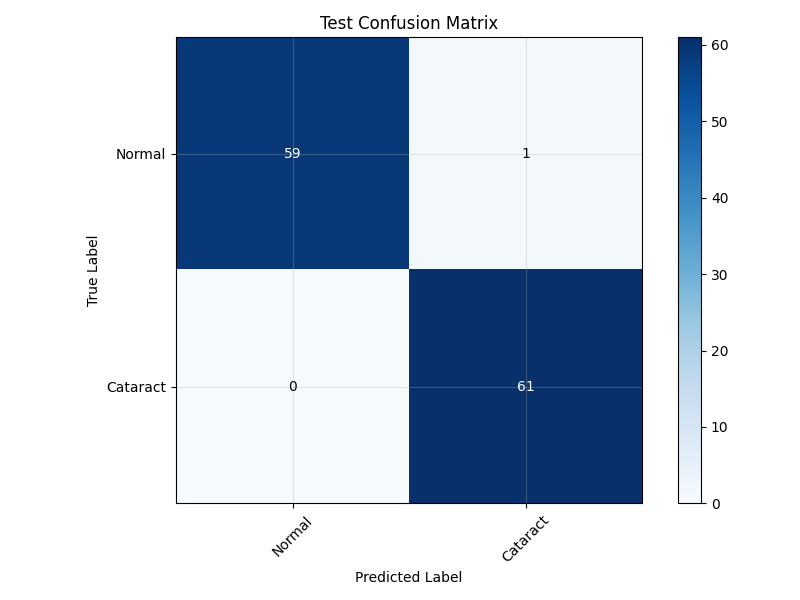


Test Set Metrics:


,Metric,Value
0,Loss,0.0760
1,Accuracy,0.9917
2,F1 Score,0.9917
3,Precision,0.9919
4,Recall,0.9917



Per-Class Performance:


,Sensitivity,Specificity,Precision,F1 Score
Normal,0.9833,1.0000,1.0000,0.9916
Cataract,1.0000,0.9833,0.9839,0.9919


In [36]:
# Cell - Display All Training Results and Metrics
from IPython.display import Image, display, Markdown, HTML
import pandas as pd

def display_training_results():
    # 1. Display training curves
    print("Training Progress Curves:")
    display(Image(filename=os.path.join(run_dir, 'training_curves.png')))
    
    # 2. Create and display metrics table
    print("\nTraining Metrics:")
    metrics_df = pd.DataFrame({
        'Epoch': training_history['epochs'],
        'Train Loss': training_history['train_loss'],
        'Val Loss': training_history['val_loss'],
        'Train Acc': training_history['train_acc'],
        'Val Acc': training_history['val_acc'],
        'Train F1': training_history['train_f1'],
        'Val F1': training_history['val_f1']
    })
    
    # Style the dataframe
    styled_df = metrics_df.style\
        .format(precision=4)\
        .background_gradient(subset=['Train Loss', 'Val Loss'], cmap='Reds')\
        .background_gradient(subset=['Train Acc', 'Val Acc'], cmap='Blues')\
        .background_gradient(subset=['Train F1', 'Val F1'], cmap='Greens')\
        .set_caption("Training History")
    
    display(styled_df)
    
    # 3. Display best model performance
    print("\nBest Model Performance:")
    print(f"Best F1 Score: {best_f1:.4f} (Epoch {best_epoch+1})")
    
    # 4. Display confusion matrix
    print("\nConfusion Matrix:")
    display(Image(filename=os.path.join(run_dir, 'test_confusion_matrix.png')))
    
    # 5. Display test metrics in a formatted way
    print("\nTest Set Metrics:")
    test_metrics_df = pd.DataFrame({
        'Metric': ['Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall'],
        'Value': [
            test_metrics['loss'],
            test_metrics['accuracy'],
            test_metrics['f1_score'],
            test_metrics['precision'],
            test_metrics['recall']
        ]
    })
    
    styled_test_df = test_metrics_df.style\
        .format({'Value': '{:.4f}'})\
        .background_gradient(subset=['Value'], cmap='viridis')\
        .set_caption("Test Set Performance")
    
    display(styled_test_df)
    
    # 6. Display per-class metrics
    print("\nPer-Class Performance:")
    cm = test_metrics['confusion_matrix']
    class_names = ['Normal', 'Cataract']
    
    # Calculate per-class metrics
    class_metrics = {}
    for i, class_name in enumerate(class_names):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        class_metrics[class_name] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1 Score': f1
        }
    
    class_metrics_df = pd.DataFrame(class_metrics).T
    styled_class_df = class_metrics_df.style\
        .format(precision=4)\
        .background_gradient(cmap='viridis')\
        .set_caption("Per-Class Metrics")
    
    display(styled_class_df)

# Display all results
display_training_results()

In [38]:
# Cell 10 - Model Optimization and Size Analysis
# Load the best model first
best_model_path = os.path.join(run_dir, 'best_model.pth')
model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
model.eval()

# Create example input
example_input = torch.randn(1, 3, 224, 224).to(device)

# Create different versions of the model
print("Creating model versions...")

# Original size
original_path = os.path.join(run_dir, 'model_original.pth')
torch.save(model.state_dict(), original_path)
original_size = os.path.getsize(original_path) / (1024 * 1024)

# Traced version
traced_model = torch.jit.trace(model, example_input)
traced_path = os.path.join(run_dir, 'model_traced.pt')
traced_model.save(traced_path)
traced_size = os.path.getsize(traced_path) / (1024 * 1024)

# Quantized version (move model to CPU for quantization)
model.to('cpu')
quantized_model = torch.quantization.quantize_dynamic(
    model,
    {torch.nn.Linear},
    dtype=torch.qint8
)
quantized_path = os.path.join(run_dir, 'model_quantized.pth')
torch.save(quantized_model.state_dict(), quantized_path)
quantized_size = os.path.getsize(quantized_path) / (1024 * 1024)

# Move model back to device
model.to(device)

# Create size comparison dictionary
model_sizes = {
    'Original': original_size,
    'Traced': traced_size,
    'Quantized': quantized_size
}

# Print sizes
print("\nModel sizes:")
for name, size in model_sizes.items():
    print(f"{name}: {size:.2f} MB")
    if name != 'Original':
        reduction = ((original_size - size) / original_size * 100)
        print(f"{name} reduction: {reduction:.2f}%")

# Plot sizes
plt.figure(figsize=(10, 6))
plt.rcParams.update({
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # Blue, Green, Orange
bars = plt.bar(range(len(model_sizes)), list(model_sizes.values()), color=colors)
plt.title('Model Size Comparison', pad=15)
plt.xlabel('Model Version')
plt.ylabel('Size (MB)')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}MB',
             ha='center', va='bottom')

plt.xticks(range(len(model_sizes)), list(model_sizes.keys()), rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(run_dir, 'model_size_comparison.png'), dpi=300, bbox_inches='tight')
plt.close()

# Test inference speed
def test_inference_speed(model, input_tensor, num_runs=50):
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            
            start.record()
            _ = model(input_tensor)
            end.record()
            
            torch.cuda.synchronize()
            times.append(start.elapsed_time(end))
    return np.mean(times)

print("\nTesting inference speeds...")
example_input = example_input.to(device)
speeds = {
    'Original': test_inference_speed(model, example_input),
    'Traced': test_inference_speed(traced_model, example_input)
}

# Print speeds and improvements
print("\nInference speeds:")
for name, speed in speeds.items():
    print(f"{name}: {speed:.2f} ms")
    if name != 'Original':
        improvement = ((speeds['Original'] - speed) / speeds['Original'] * 100)
        print(f"{name} speed improvement: {improvement:.2f}%")

# Save detailed results
with open(os.path.join(run_dir, 'optimization_results.txt'), 'w') as f:
    f.write("Model Size Comparison\n")
    f.write("===================\n")
    for name, size in model_sizes.items():
        f.write(f"{name}: {size:.2f} MB\n")
        if name != 'Original':
            reduction = ((original_size - size) / original_size * 100)
            f.write(f"{name} reduction: {reduction:.2f}%\n")
    
    f.write("\nInference Speed Comparison\n")
    f.write("========================\n")
    for name, speed in speeds.items():
        f.write(f"{name}: {speed:.2f} ms\n")
        if name != 'Original':
            improvement = ((speeds['Original'] - speed) / speeds['Original'] * 100)
            f.write(f"{name} speed improvement: {improvement:.2f}%\n")

print(f"\nResults saved to {run_dir}")

Creating model versions...

Model sizes:
Original: 246.12 MB
Traced: 246.57 MB
Traced reduction: -0.18%
Quantized: 206.26 MB
Quantized reduction: 16.19%

Testing inference speeds...

Inference speeds:
Original: 10.70 ms
Traced: 8.31 ms
Traced speed improvement: 22.37%

Results saved to e:\jivi-ai\results\run_20241025_203223


Model Size Comparison:


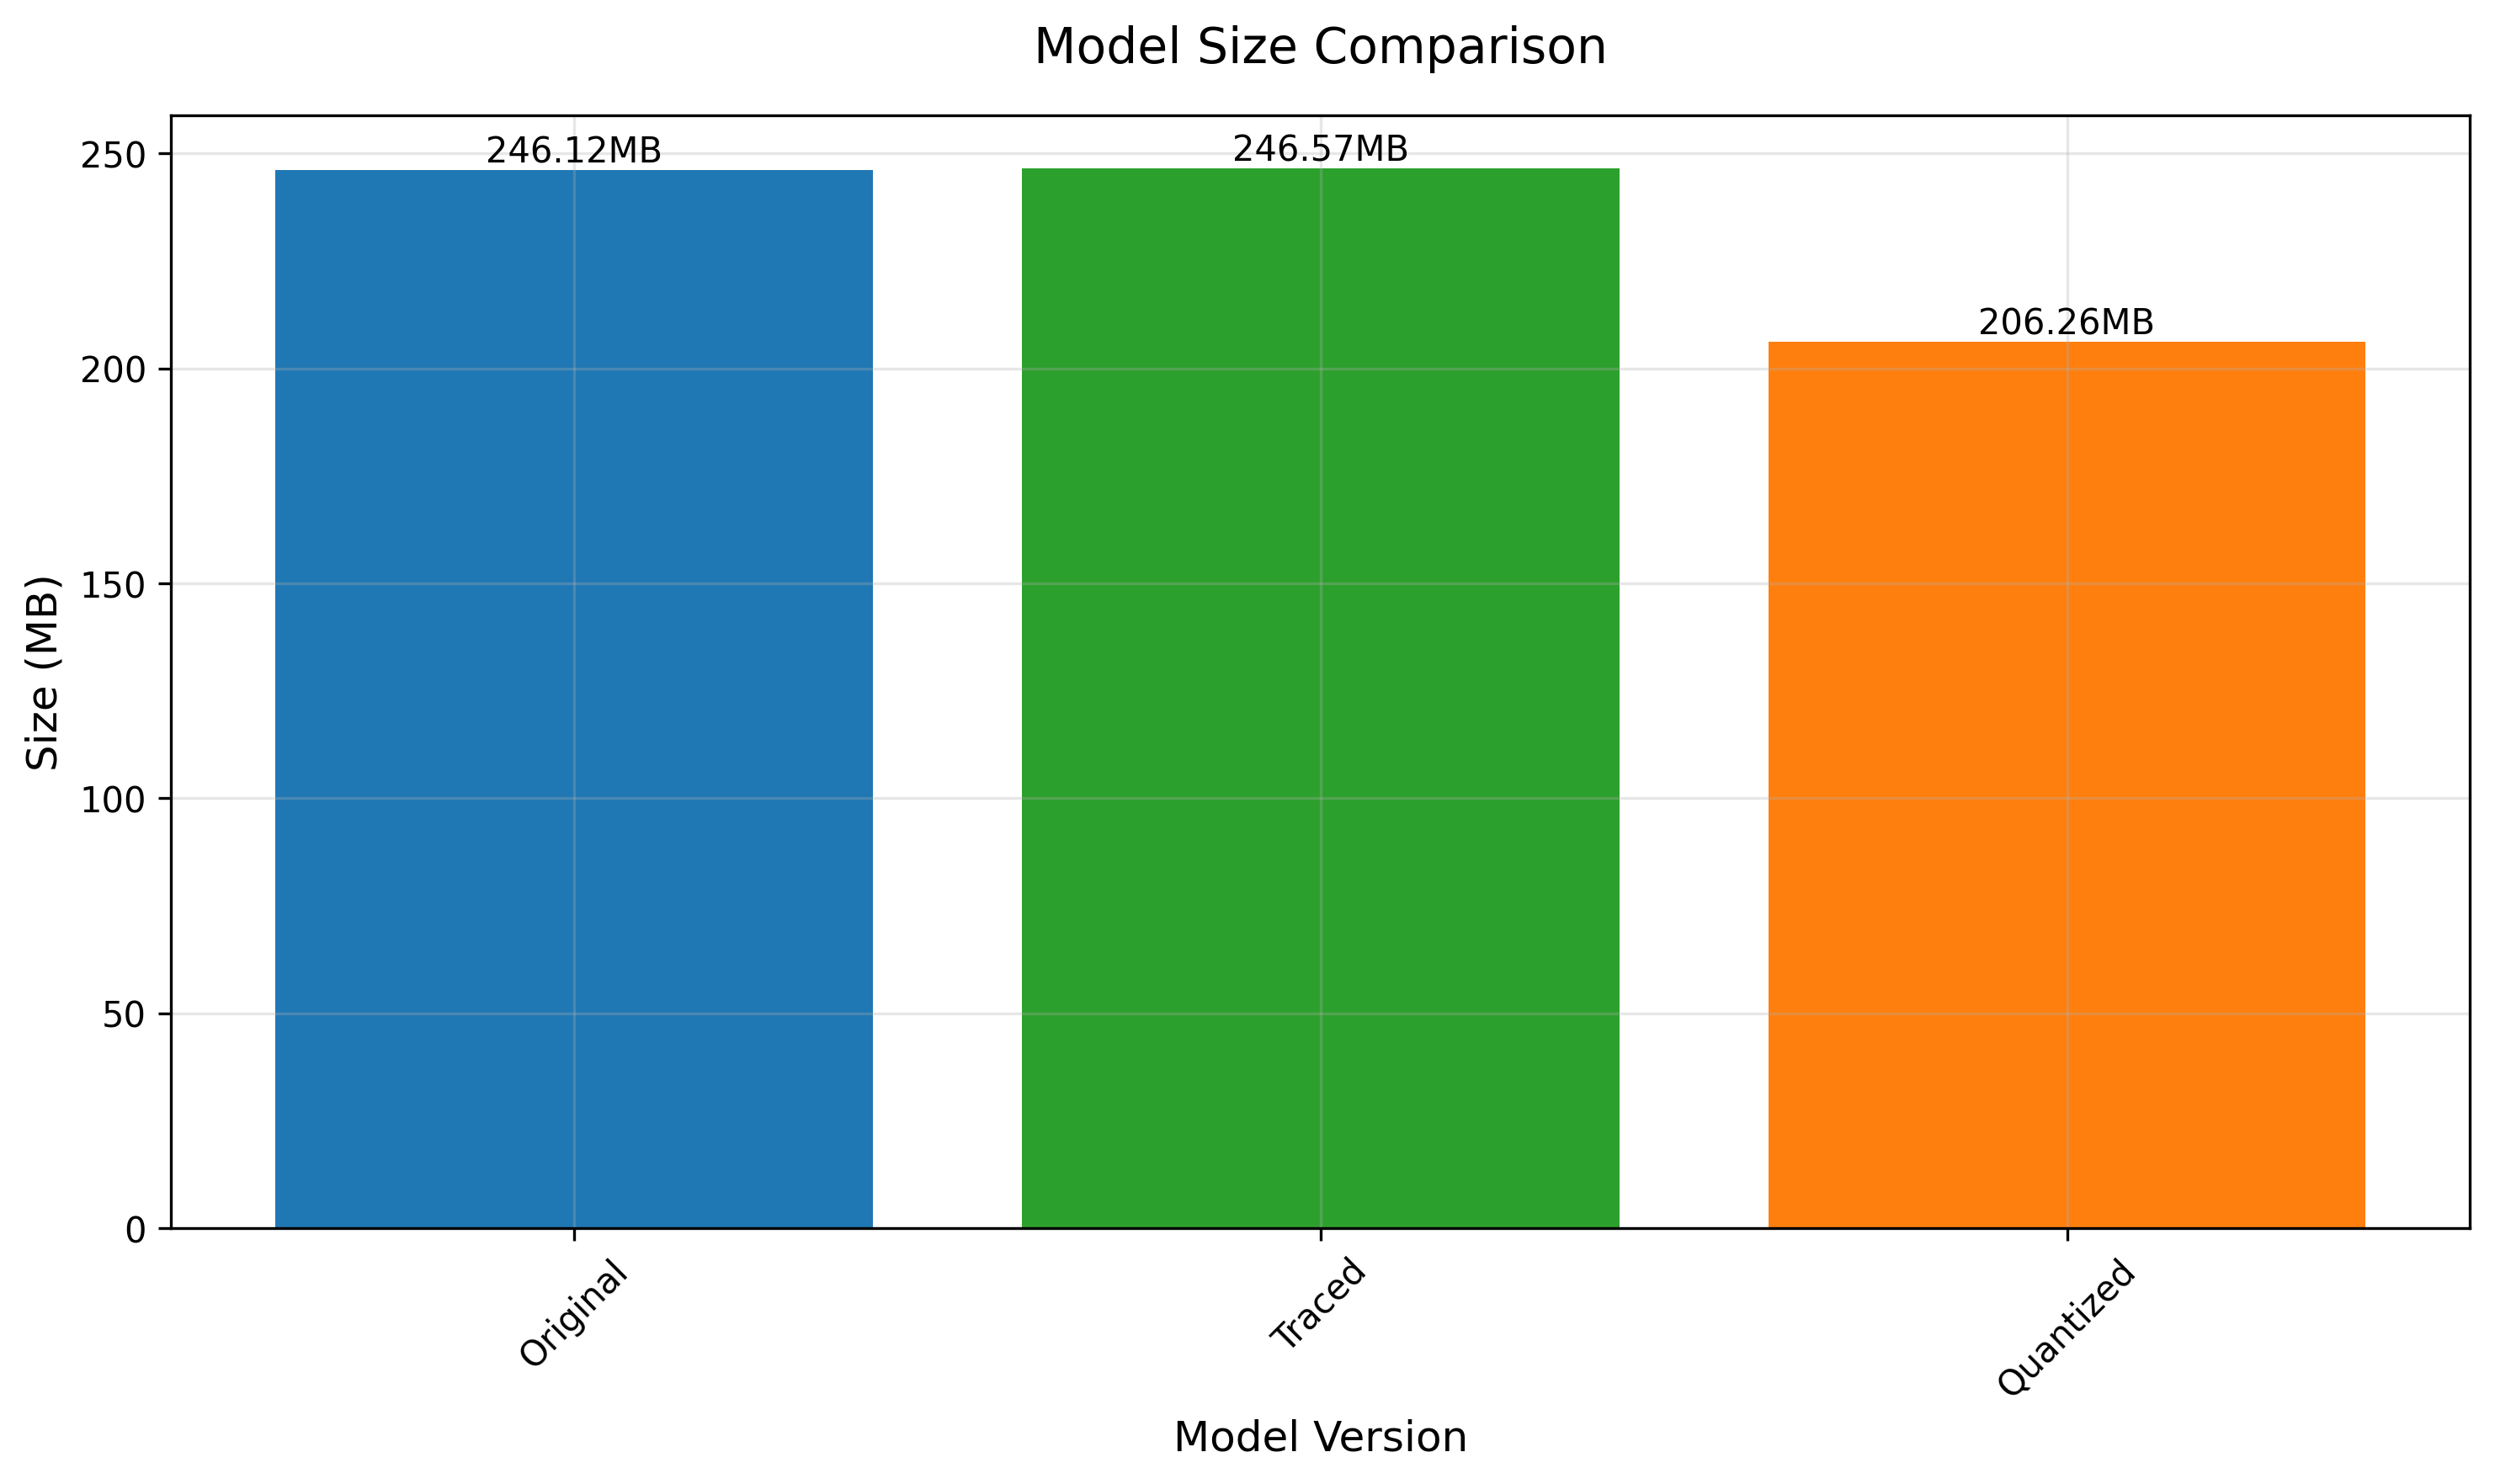


Detailed Results:


```
Model Size Comparison
===================
Original: 246.12 MB
Traced: 246.57 MB
Traced reduction: -0.18%
Quantized: 206.26 MB
Quantized reduction: 16.19%

Inference Speed Comparison
========================
Original: 10.70 ms
Traced: 8.31 ms
Traced speed improvement: 22.37%

```

In [39]:
# Cell - Display Optimization Results
from IPython.display import Image, display, Markdown

def show_optimization_results():
    # Display model size comparison plot
    print("Model Size Comparison:")
    display(Image(filename=os.path.join(run_dir, 'model_size_comparison.png')))
    
    # Display results from the text file
    print("\nDetailed Results:")
    with open(os.path.join(run_dir, 'optimization_results.txt'), 'r') as f:
        results = f.read()
        display(Markdown(f"```\n{results}\n```"))

show_optimization_results()